In [55]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.preprocessing import fix_data_types, merge_geolocation, clean_data, add_features

# Ensure path for src imports
sys.path.append(os.path.abspath(".."))

# Ecommerce Fraud Detection: Exploratory Data Analysis (EDA)

This notebook performs data cleaning, preprocessing, feature engineering, and EDA for the fraud detection project.

In [56]:
fraud_df = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_df = pd.read_csv("../data/raw/IpAddress_to_Country.csv")

## 1. Data Loading

Load the raw fraud and IP datasets to begin analysis.

## 2. Data Type Corrections

Convert IP addresses to integers and dates to datetime objects to prevent precision errors and enable time-based operations.

In [57]:
fraud_df, ip_df = fix_data_types(fraud_df, ip_df)

## 3. Geolocation Merge

Merge fraud data with IP-to-country mappings using approximate matching to add country information for geographic analysis.

In [58]:
merged_df = merge_geolocation(fraud_df, ip_df)

In [59]:
print("Merge Complete. Sample:")

print(merged_df[["user_id", "country", "class"]].head(10))

Merge Complete. Sample:
     user_id    country  class
634   247547  Australia      0
635   220737   Thailand      0
636   390400      China      0
637    69592      China      0
638   174987   Thailand      0
639    23204      China      0
640   155230   Thailand      0
641   199369      Japan      0
642   236894      Japan      0
643   379446      Japan      0


## 4. Final Cleaning

Handle missing values and remove duplicates to ensure data integrity.

In [60]:
merged_df = clean_data(merged_df)

In [61]:
# Final Shape Check
print(f"Final Cleaned Data Shape: {merged_df.shape}")


Final Cleaned Data Shape: (129146, 14)


## 5. Data Visualizations

Generate key visualizations to understand the data distributions and fraud patterns.

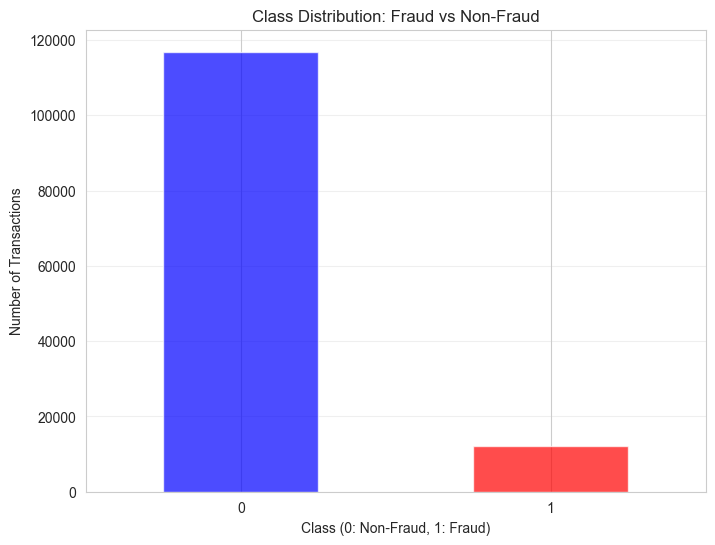

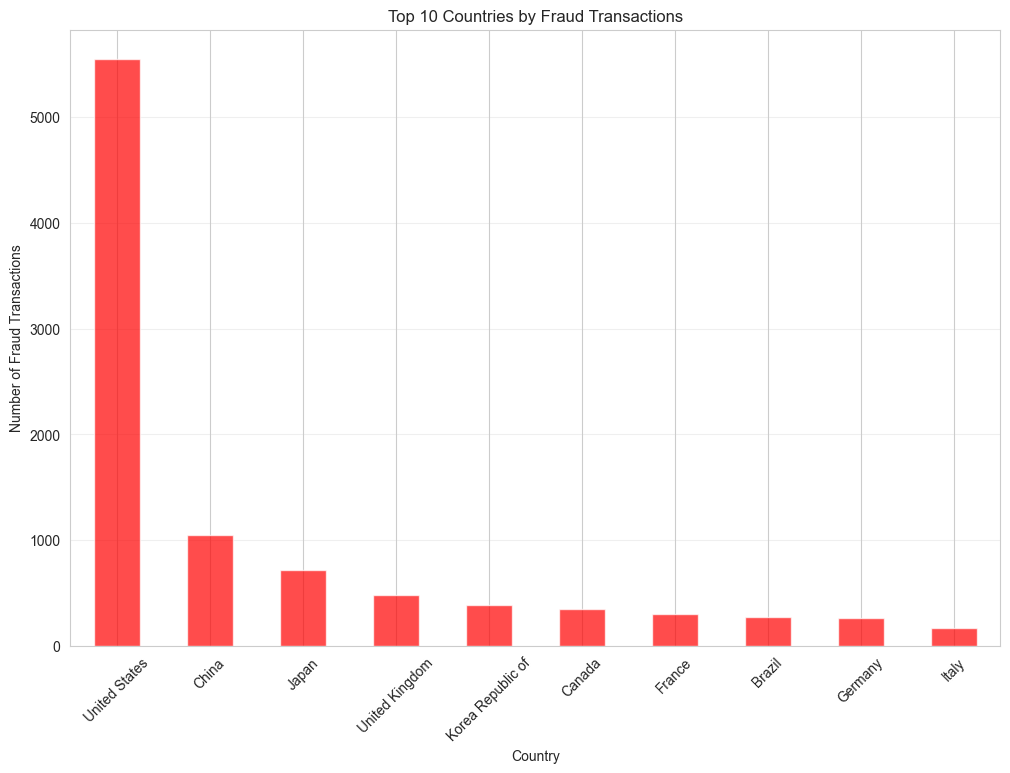

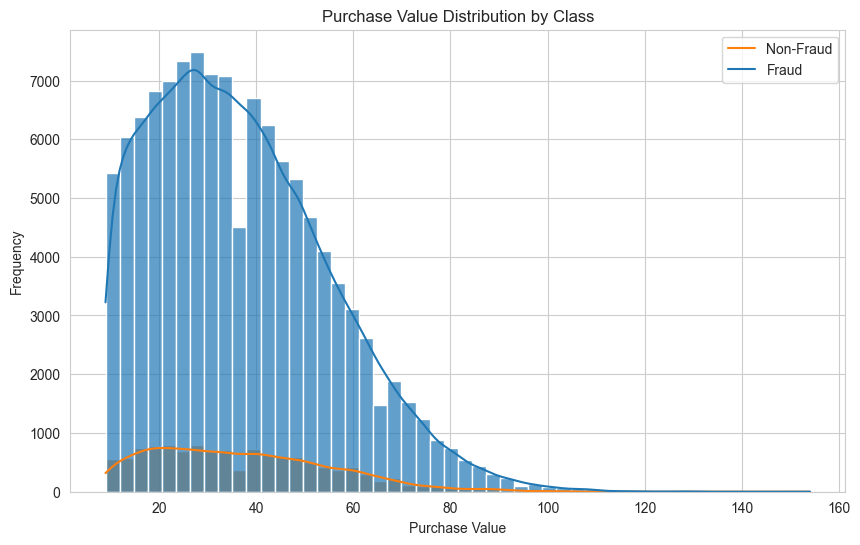

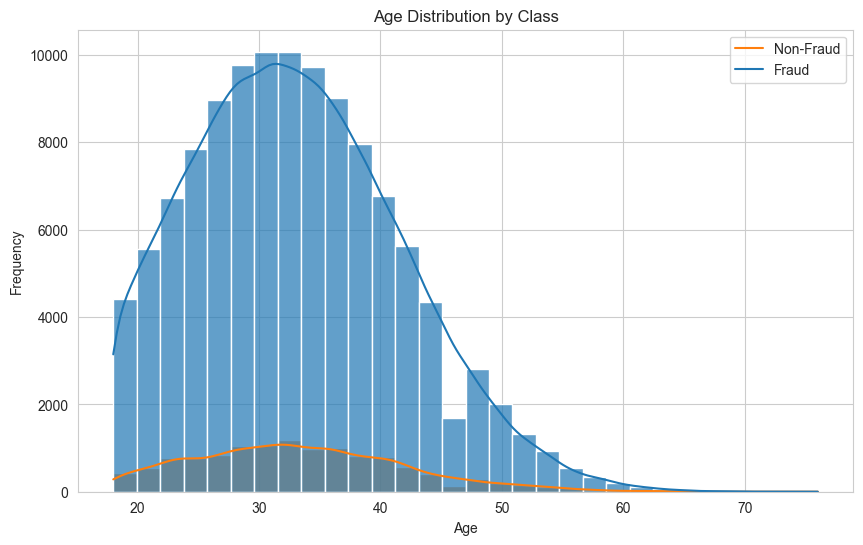

Visualizations generated and saved to images/ folder.


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# 1. Class Distribution
plt.figure(figsize=(8, 6))
class_counts = merged_df['class'].value_counts()
class_counts.plot(kind='bar', color=['blue', 'red'], alpha=0.7)
plt.title('Class Distribution: Fraud vs Non-Fraud')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.savefig('../images/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Fraud by Country (Top 10)
plt.figure(figsize=(12, 8))
fraud_by_country.head(10).plot(kind='bar', color='red', alpha=0.7)
plt.title('Top 10 Countries by Fraud Transactions')
plt.xlabel('Country')
plt.ylabel('Number of Fraud Transactions')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.savefig('../images/fraud_by_country.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Purchase Value Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_df, x='purchase_value', hue='class', bins=50, alpha=0.7, kde=True)
plt.title('Purchase Value Distribution by Class')
plt.xlabel('Purchase Value')
plt.ylabel('Frequency')
plt.legend(['Non-Fraud', 'Fraud'])
plt.savefig('../images/purchase_value_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_df, x='age', hue='class', bins=30, alpha=0.7, kde=True)
plt.title('Age Distribution by Class')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(['Non-Fraud', 'Fraud'])
plt.savefig('../images/age_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualizations generated and saved to images/ folder.")